In [1]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [2]:
#Loading Dataset
data = pd.read_csv('spam.csv')

#displaying the first 5 rows
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
#Loading validation dataset
os.getcwd()
valid_data=pd.read_csv('CCAC_data_body.csv')

In [4]:
data.shape

(10743, 5)

In [5]:
valid_data.shape

(4898, 2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10743 entries, 0 to 10742
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          10743 non-null  object
 1   v2          10743 non-null  object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 419.8+ KB


In [7]:
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      4898 non-null   int64 
 1   Body    4730 non-null   object
dtypes: int64(1), object(1)
memory usage: 76.7+ KB


In [8]:
# Dropping the columns
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
valid_data.head()

,Id,Body
0,1,Thank you! I just sent a hold time. I will ca...
1,2,"Over the past 8 months, System Planning has be..."
2,3,_________________________________________...
3,4,_______________________________...
4,5,"One I confirm a date and time with Julie, I wi..."


In [10]:
type(data["Text"])

pandas.core.series.Series

In [11]:
valid_data["Body"]=valid_data["Body"].apply(str)
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      4898 non-null   int64 
 1   Body    4898 non-null   object
dtypes: int64(1), object(1)
memory usage: 76.7+ KB


In [12]:
valid_data.head()

,Id,Body
0,1,Thank you! I just sent a hold time. I will ca...
1,2,"Over the past 8 months, System Planning has be..."
2,3,_________________________________________...
3,4,_______________________________...
4,5,"One I confirm a date and time with Julie, I wi..."


In [13]:
type(valid_data["Body"])

pandas.core.series.Series

Text(0, 0.5, 'Number of Data points')

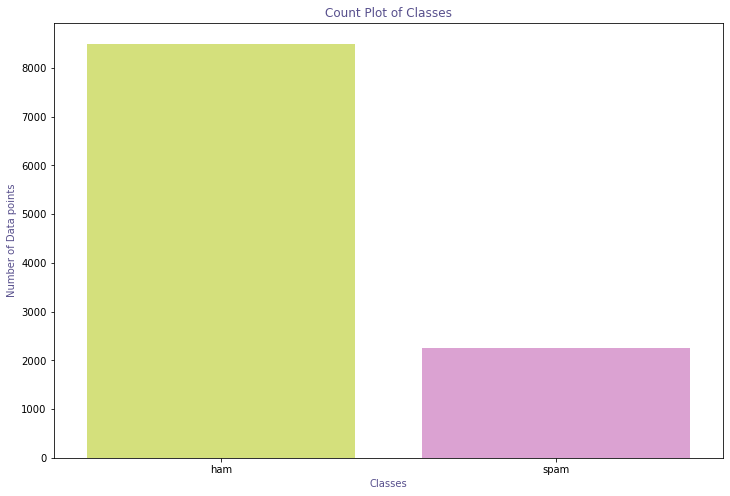

In [14]:
#Palette
cols= ["#E1F16B", "#E598D8"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

In [15]:
#Adding a column of numbers of characters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
#Adding a column of numbers of characters,words and sentences in each msg
valid_data["No_of_Characters"]=valid_data["Body"].apply(len)

In [16]:
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
valid_data["No_of_Words"]=valid_data.apply(lambda row: nltk.word_tokenize(row["Body"]), axis=1).apply(len)

In [17]:
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)
valid_data["No_of_sentence"]=valid_data.apply(lambda row: nltk.sent_tokenize(row["Body"]), axis=1).apply(len)

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,10743.0,546.152378,1166.368879,2.0,55.0,142.0,510.5,32258.0
No_of_Words,10743.0,120.012194,256.227140,1.0,13.0,30.0,115.0,8863.0
No_of_sentence,10743.0,7.311645,19.219127,1.0,1.0,3.0,7.0,1204.0


In [19]:
valid_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4898.0,2449.500000,1414.075139,1.0,1225.25,2449.5,3673.75,4898.0
No_of_Characters,4898.0,2353.245406,3155.931205,2.0,494.25,1422.0,2977.25,30941.0
No_of_Words,4898.0,395.364230,553.440433,0.0,83.00,201.0,510.75,6365.0
No_of_sentence,4898.0,14.163944,22.948680,0.0,2.00,6.0,16.00,215.0


<Figure size 864x576 with 0 Axes>

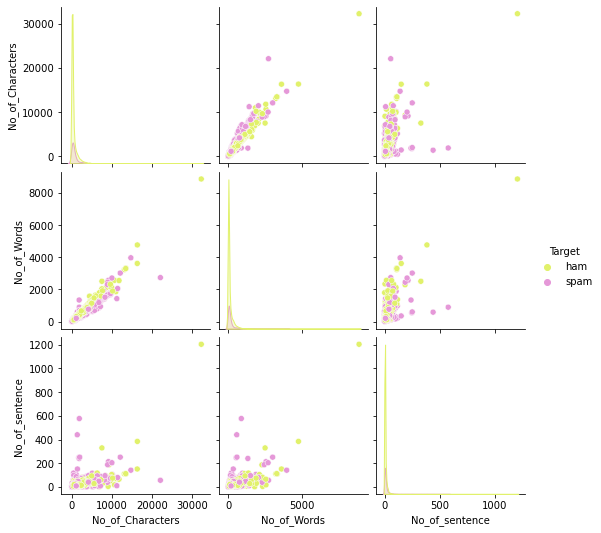

In [20]:
#Dropping Outliers
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

In [21]:
#data = data[(data["No_of_Characters"]<350)]
#data.shape

(7325, 5)

<Figure size 864x576 with 0 Axes>

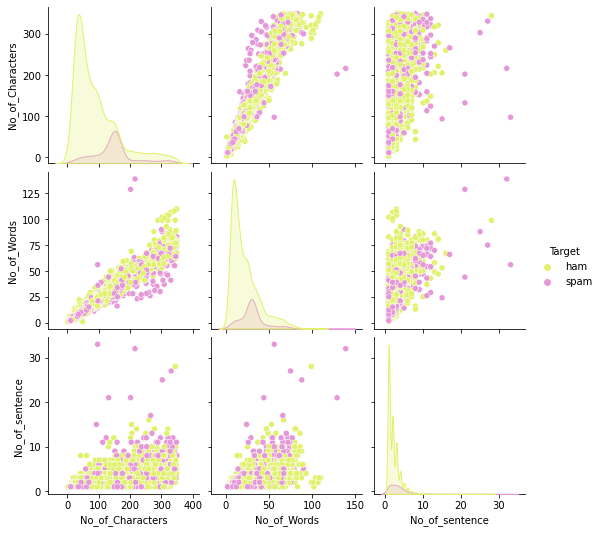

In [22]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

### Data preprocessing

In [20]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [21]:
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*valid_data["Body"][:5], sep = "\n")

 The First 5 Texts:
Thank you! I just sent a hold time.  I will cancel if we decide we don?t need.         From: Mohdhafi Agdern <email@yyyy.zzz>   Sent: Friday, November 19, 2021 1:33 PM  To: Brandon Aristeo Akcali <email@yyyy.zzz>  Cc: Suchit Aiyer <email@yyyy.zzz>  Subject: [EXT]Re: December meeting request              ________________________________    Hi Brandon,         Ram can meet on the 21st or 22nd for half an hour on any time between 7am PT to 9am.         Let me know if a time in there works for you, and we can potentially invite Oskar and Chad.         Regards,'              Mohdhafi Agdern    Civil & Environmental Engineering    Jerry Yang & Akiko Yamazaki Environment & Energy Building    473 Via Ortega    Stanford, CA 94305    ###-###-#### (m)         ________________________________    From: Brandon Aristeo Akcali <email@yyyy.zzz <mailto:email@yyyy.zzz> >  Sent: Friday, November 19, 2021 10:01 AM  To: Mohdhafi Agdern <email@yyyy.zzz <mailto:email@yyyy.zzz> >  Cc: Such

In [22]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [23]:
valid_data["Clean_Text"] = valid_data["Body"].apply(Clean)
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*valid_data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
thank you i just sent a hold time i will cancel if we decide we don t need from mohdhafi agdern email yyyy zzz sent friday november pm to brandon aristeo akcali email yyyy zzz cc suchit aiyer email yyyy zzz subject ext re december meeting request hi brandon ram can meet on the st or nd for half an hour on any time between am pt to am let me know if a time in there works for you and we can potentially invite oskar and chad regards mohdhafi agdern civil environmental engineering jerry yang akiko yamazaki environment energy building via ortega stanford ca m from brandon aristeo akcali email yyyy zzz mailto email yyyy zzz sent friday november am to mohdhafi agdern email yyyy zzz mailto email yyyy zzz cc suchit aiyer email yyyy zzz mailto email yyyy zzz subject december meeting request tiffany i hope you are doing well i was hoping you could suggest options of time for a meeting with ram to go over the nda language with our legal and supply mgmt team i am 

#### Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words. I am splitting the Clean_Text into words at this step.

In [24]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [25]:
valid_data["Tokenize_Text"]=valid_data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*valid_data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['thank', 'you', 'i', 'just', 'sent', 'a', 'hold', 'time', 'i', 'will', 'cancel', 'if', 'we', 'decide', 'we', 'don', 't', 'need', 'from', 'mohdhafi', 'agdern', 'email', 'yyyy', 'zzz', 'sent', 'friday', 'november', 'pm', 'to', 'brandon', 'aristeo', 'akcali', 'email', 'yyyy', 'zzz', 'cc', 'suchit', 'aiyer', 'email', 'yyyy', 'zzz', 'subject', 'ext', 're', 'december', 'meeting', 'request', 'hi', 'brandon', 'ram', 'can', 'meet', 'on', 'the', 'st', 'or', 'nd', 'for', 'half', 'an', 'hour', 'on', 'any', 'time', 'between', 'am', 'pt', 'to', 'am', 'let', 'me', 'know', 'if', 'a', 'time', 'in', 'there', 'works', 'for', 'you', 'and', 'we', 'can', 'potentially', 'invite', 'oskar', 'and', 'chad', 'regards', 'mohdhafi', 'agdern', 'civil', 'environmental', 'engineering', 'jerry', 'yang', 'akiko', 'yamazaki', 'environment', 'energy', 'building', 'via', 'ortega', 'stanford', 'ca', 'm', 'from', 'brandon', 'aristeo', 'akcali', 'email', 'yyyy', 'zzz', 'mailto', 'email', 

#### Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.

In [26]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [27]:
valid_data["Nostopword_Text"] = valid_data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*valid_data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['thank', 'sent', 'hold', 'time', 'cancel', 'decide', 'need', 'mohdhafi', 'agdern', 'email', 'yyyy', 'zzz', 'sent', 'friday', 'november', 'pm', 'brandon', 'aristeo', 'akcali', 'email', 'yyyy', 'zzz', 'cc', 'suchit', 'aiyer', 'email', 'yyyy', 'zzz', 'subject', 'ext', 'december', 'meeting', 'request', 'hi', 'brandon', 'ram', 'meet', 'st', 'nd', 'half', 'hour', 'time', 'pt', 'let', 'know', 'time', 'works', 'potentially', 'invite', 'oskar', 'chad', 'regards', 'mohdhafi', 'agdern', 'civil', 'environmental', 'engineering', 'jerry', 'yang', 'akiko', 'yamazaki', 'environment', 'energy', 'building', 'via', 'ortega', 'stanford', 'ca', 'brandon', 'aristeo', 'akcali', 'email', 'yyyy', 'zzz', 'mailto', 'email', 'yyyy', 'zzz', 'sent', 'friday', 'november', 'mohdhafi', 'agdern', 'email', 'yyyy', 'zzz', 'mailto', 'email', 'yyyy', 'zzz', 'cc', 'suchit', 'aiyer', 'email', 'yyyy', 'zzz', 'mailto', 'email', 'yyyy', 'zzz', 'subject', 'december', 'meeting', '

Stemming is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

lemmatization also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

In [28]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


In [29]:
valid_data["Lemmatized_Text"] = valid_data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*valid_data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['thank', 'send', 'hold', 'time', 'cancel', 'decide', 'need', 'mohdhafi', 'agdern', 'email', 'yyyy', 'zzz', 'send', 'friday', 'november', 'pm', 'brandon', 'aristeo', 'akcali', 'email', 'yyyy', 'zzz', 'cc', 'suchit', 'aiyer', 'email', 'yyyy', 'zzz', 'subject', 'ext', 'december', 'meet', 'request', 'hi', 'brandon', 'ram', 'meet', 'st', 'nd', 'half', 'hour', 'time', 'pt', 'let', 'know', 'time', 'work', 'potentially', 'invite', 'oskar', 'chad', 'regard', 'mohdhafi', 'agdern', 'civil', 'environmental', 'engineer', 'jerry', 'yang', 'akiko', 'yamazaki', 'environment', 'energy', 'build', 'via', 'ortega', 'stanford', 'ca', 'brandon', 'aristeo', 'akcali', 'email', 'yyyy', 'zzz', 'mailto', 'email', 'yyyy', 'zzz', 'send', 'friday', 'november', 'mohdhafi', 'agdern', 'email', 'yyyy', 'zzz', 'mailto', 'email', 'yyyy', 'zzz', 'cc', 'suchit', 'aiyer', 'email', 'yyyy', 'zzz', 'mailto', 'email', 'yyyy', 'zzz', 'subject', 'december', 'meet', 'request', 'tiffany', 'ho

In [30]:
data.head()


,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"


In [31]:
valid_data.head()

,Id,Body,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,1,Thank you! I just sent a hold time. I will ca...,1485,304,12,thank you i just sent a hold time i will cance...,"[thank, you, i, just, sent, a, hold, time, i, ...","[thank, sent, hold, time, cancel, decide, need...","[thank, send, hold, time, cancel, decide, need..."
1,2,"Over the past 8 months, System Planning has be...",1028,167,8,over the past months system planning has been ...,"[over, the, past, months, system, planning, ha...","[past, months, system, planning, partnering, e...","[past, months, system, plan, partner, energy, ..."
2,3,_________________________________________...,1379,177,1,microsoft teams meeting join on your computer ...,"[microsoft, teams, meeting, join, on, your, co...","[microsoft, teams, meeting, join, computer, mo...","[microsoft, team, meet, join, computer, mobile..."
3,4,_______________________________...,1175,133,1,microsoft teams meeting join on your computer ...,"[microsoft, teams, meeting, join, on, your, co...","[microsoft, teams, meeting, join, computer, mo...","[microsoft, team, meet, join, computer, mobile..."
4,5,"One I confirm a date and time with Julie, I wi...",74,18,1,one i confirm a date and time with julie i wil...,"[one, i, confirm, a, date, and, time, with, ju...","[one, confirm, date, time, julie, update, holds]","[one, confirm, date, time, julie, update, hold]"


TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

Steps in the Vectorizing:

Creating a corpus of lemmatized text
Converting the corpus in vector form
Label Encoding the classes in Target
Note: So far we have been stalking up columns in our data for the purpose of explanation

In [32]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [33]:
len(corpus)

10743

In [34]:
#Creating a corpus of text feature to encode further into vectorized form
corpus_v= []
for i in valid_data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus_v.append(msg)
    
corpus_v[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus_v[:5], sep = "\n")

 The First 5 lines in corpus :
thank send hold time cancel decide need mohdhafi agdern email yyyy zzz send friday november pm brandon aristeo akcali email yyyy zzz cc suchit aiyer email yyyy zzz subject ext december meet request hi brandon ram meet st nd half hour time pt let know time work potentially invite oskar chad regard mohdhafi agdern civil environmental engineer jerry yang akiko yamazaki environment energy build via ortega stanford ca brandon aristeo akcali email yyyy zzz mailto email yyyy zzz send friday november mohdhafi agdern email yyyy zzz mailto email yyyy zzz cc suchit aiyer email yyyy zzz mailto email yyyy zzz subject december meet request tiffany hope well hop could suggest options time meet ram go nda language legal supply mgmt team think week dec th th would good target way get hold ram please let us know oskar chad invite thank brandon aristeo akcali
past months system plan partner energy exemplar https www energyexemplar com explore technology solutions business n

In [35]:
len(corpus_v)

4898

In [36]:
combcor=corpus+corpus_v

In [37]:
type(combcor)

list

In [38]:
len(combcor)

15641

In [39]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [40]:
#Changing text data in to numbers. 
tfidf_v = TfidfVectorizer()
X_v = tfidf_v.fit_transform(corpus_v).toarray()
#Let's have a look at our feature 
X_v.dtype

dtype('float64')

In [41]:
#Changing text data in to numbers. 
tfidf_c = TfidfVectorizer()
X_c = tfidf_c.fit_transform(combcor).toarray()
#Let's have a look at our feature 
X_c.dtype

dtype('float64')

In [42]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

#### Model Building

In [43]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"] 
# Splitting the testing and training sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [113]:
# Crossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.892132 
RandomForest: 0.951129 
KNeighbours: 0.836050 
SVC: 0.949965 


In [44]:
RF=RandomForestClassifier()

In [45]:
RF.fit(X_c[:10743],y[:10743])

RandomForestClassifier()

In [46]:
y_pred=RF.predict(X_c[10743:15641])

In [47]:
y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [48]:
valid_data["Target"]=y_pred

In [49]:
valid_data

,Id,Body,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text,Target
0,1,Thank you! I just sent a hold time. I will ca...,1485,304,12,thank you i just sent a hold time i will cance...,"[thank, you, i, just, sent, a, hold, time, i, ...","[thank, sent, hold, time, cancel, decide, need...","[thank, send, hold, time, cancel, decide, need...",0
1,2,"Over the past 8 months, System Planning has be...",1028,167,8,over the past months system planning has been ...,"[over, the, past, months, system, planning, ha...","[past, months, system, planning, partnering, e...","[past, months, system, plan, partner, energy, ...",0
2,3,_________________________________________...,1379,177,1,microsoft teams meeting join on your computer ...,"[microsoft, teams, meeting, join, on, your, co...","[microsoft, teams, meeting, join, computer, mo...","[microsoft, team, meet, join, computer, mobile...",1
3,4,_______________________________...,1175,133,1,microsoft teams meeting join on your computer ...,"[microsoft, teams, meeting, join, on, your, co...","[microsoft, teams, meeting, join, computer, mo...","[microsoft, team, meet, join, computer, mobile...",0
4,5,"One I confirm a date and time with Julie, I wi...",74,18,1,one i confirm a date and time with julie i wil...,"[one, i, confirm, a, date, and, time, with, ju...","[one, confirm, date, time, julie, update, holds]","[one, confirm, date, time, julie, update, hold]",0
...,...,...,...,...,...,...,...,...,...,...
4893,4894,Haha- no worries. I made some tweaks around t...,5756,974,33,haha no worries i made some tweaks around the ...,"[haha, no, worries, i, made, some, tweaks, aro...","[haha, worries, made, tweaks, around, learning...","[haha, worry, make, tweak, around, learn, work...",0
4894,4895,Out on PTO,19,3,1,out on pto,"[out, on, pto]",[pto],[pto],0
4895,4896,This makes sense to me. From: Diane M ...,2930,622,23,this makes sense to me from diane m aboo email...,"[this, makes, sense, to, me, from, diane, m, a...","[makes, sense, diane, aboo, email, yyyy, zzz, ...","[make, sense, diane, aboo, email, yyyy, zzz, s...",0
4896,4897,Some ideas for use cases for 8/9 meeting ...,1122,182,8,some ideas for use cases for meeting to discus...,"[some, ideas, for, use, cases, for, meeting, t...","[ideas, use, cases, meeting, discuss, based, c...","[ideas, use, case, meet, discuss, base, chat, ...",0


In [50]:
to_drop_1 = ["No_of_Characters","No_of_Words","No_of_sentence","Clean_Text","Tokenize_Text","Nostopword_Text","Lemmatized_Text"]
submission = valid_data.drop(data[to_drop_1], axis=1)

In [51]:
submission.head()

,Id,Body,Target
0,1,Thank you! I just sent a hold time. I will ca...,0
1,2,"Over the past 8 months, System Planning has be...",0
2,3,_________________________________________...,1
3,4,_______________________________...,0
4,5,"One I confirm a date and time with Julie, I wi...",0


In [52]:
submission.to_csv("submission_file1.csv",index=False)

In [33]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
    
       #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)